In [2]:
import numpy as np
from fenics import *
from skopt.sampler import Lhs
from skopt.space import Space
import scipy.io as sio

Invalid MIT-MAGIC-COOKIE-1 key

In [3]:
# Use Latin Hypercube Sampling to generate samples for the parameters alpha, beta and gamma
space_lhs = Space([(1., 10.), (0, np.pi/2), (0, np.pi/2)]) # define the space of the parameters for alpha, beta and gamma
lhs = Lhs(lhs_type="classic", criterion="maximin", iterations=1000)

n_echantillons = 1
lhs_samples = np.array(lhs.generate(space_lhs.dimensions, n_echantillons))
sio.savemat('lhs_samples.mat', {'lhs_samples': lhs_samples})

In [4]:
def boundary_R(x, on_boundary):
    return on_boundary and near(x[0], 1.0, 1E-14)

def boundary_R_barre(x, on_boundary):
    return on_boundary and not(near(x[0], 1.0, 1E-14))

u_R = Expression('cos(2 * pi * x[1])', degree=2)
u_R_barre = Constant(1.0)

In [5]:
import scipy.ndimage as ndimage
def reshape_fenics_vector(u, mesh, square_dim):
    coordinates = mesh.coordinates()
    vertex_values = u.compute_vertex_values(mesh)

    combined_info = list(zip(coordinates, vertex_values))
    combined_info.sort(key=lambda x: (x[0][0]))

    coordinates_sorted = [x[0] for x in combined_info]
    vertex_values_sorted = [x[1] for x in combined_info]

    return ndimage.rotate(np.reshape(vertex_values_sorted, (square_dim, square_dim))  , 90) 

In [11]:
nx, ny = 99, 99
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'P', 1)
coordinates = V.tabulate_dof_coordinates()
bc_R = DirichletBC(V, u_R, boundary_R)
bc_R_barre = DirichletBC(V, u_R_barre, boundary_R_barre)
bcs = [bc_R_barre, bc_R]
source_term_str = 'alpha * pow(pi, 2) * (x[0]*x[0] + x[1]*x[1]) * sin(pi*(x[0] + beta)*(x[1] + gamma))'

source_term_list = []
u_list = []

for alpha, beta, gamma in lhs_samples:

    source_term = Expression(source_term_str, alpha=alpha, beta=beta, gamma=gamma, degree=2)
    source_term = project(source_term, V)
    u = TrialFunction(V)
    v = TestFunction(V)
    a = dot(grad(u), grad(v)) * dx
    L = source_term * v * dx 

    u = Function(V)
    solve(a == L, u, bcs)

    coordinates = mesh.coordinates()
    source_term_values, u_values = source_term.vector().get_local(), u.vector().get_local()
    source_term_values, u_values = reshape_fenics_vector(source_term, mesh, nx+1), reshape_fenics_vector(u, mesh, nx+1)

    source_term_list.append(source_term_values)
    u_list.append(u_values)

# sio.savemat('source_term.mat', {'source_term': source_term_list})
# sio.savemat('u.mat', {'u': u_list})
    

Solving linear variational problem.


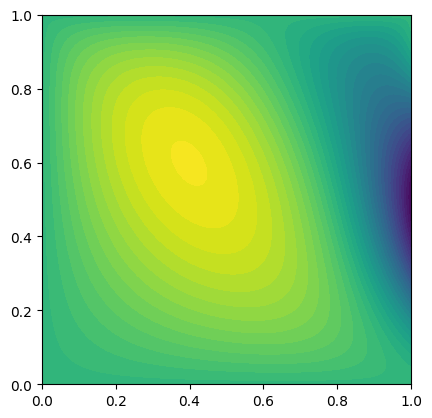

In [12]:
plot(u)